In [29]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'figure.figsize': [10, 6]})

In [2]:
connection = psycopg2.connect(
    user="postgres",
    password="postgres",
    host="127.0.0.1",
    port="54320",
    database="stack_overflow",
)

In [3]:
with connection:
    with connection.cursor() as cursor:
        cursor.execute(
            """select count(*)
        from posts_19"""
        )
        total_posts_19 = cursor.fetchall()
total_posts_19

[(17074987,)]

In [4]:
with connection:
    with connection.cursor() as cursor:
        cursor.execute(
            """select count(*)
        from users"""
        )
        total_users = cursor.fetchall()
total_users

[(19307021,)]

In [52]:
with connection:
    with connection.cursor() as cursor:
        cursor.execute(
            """
            select count(distinct(u.id))
            from users u
            join posts_19 p ON p.owner_user_id=u.id
            """
        )
        total_users = cursor.fetchall()
total_users

[(3297276,)]

In [5]:

with connection:
    with connection.cursor() as cursor:
        cursor.execute(
            """SELECT avg(q_a.score), u.high_hdi
                    FROM users u
                    JOIN posts_19 q_a ON q_a.owner_user_id=u.id
                    where u.high_hdi IS NOT NULL
                    and q_a.score IS NOT NULL
                    group by u.high_hdi"""
        )
        scores = cursor.fetchall()
scores

[(Decimal('3.1655728352140954'), False), (Decimal('5.4948254551170301'), True)]

puntajes por pais

preguntas de python por pais

respuestas de python por pais

respuestas aceptadas de python por pais

puntaje promedio de respuestas de python por pais


In [6]:
with connection:
    with connection.cursor() as cursor:
        cursor.execute(
            """
        select count(*)
        from posts_19 p
        join posts_19_tags pt on pt.post_id=p.id
        join tags t on pt.tag_id=t.id
        where p.body_text is not null
        and p.post_type_id=1 
        and creation_date < '2022-01-01'
        and t.tag_name = 'python'"""
        )
        train_posts = cursor.fetchall()
train_posts

[(896946,)]

In [7]:
with connection:
    with connection.cursor() as cursor:
        cursor.execute(
            """
        select sum(answer_count)
        from posts_19 p
        join posts_19_tags pt on pt.post_id=p.id
        join tags t on pt.tag_id=t.id
        where p.body_text is not null
        and p.post_type_id=1
        and creation_date < '2022-01-01'
        and t.tag_name = 'python'"""
        )
        train_a = cursor.fetchall()
train_a

[(1360179,)]

In [8]:
with connection:
    with connection.cursor() as cursor:
        cursor.execute(
            """
        select count(*)
        from posts_19 p
        join posts_19_tags pt on pt.post_id=p.id
        join tags t on pt.tag_id=t.id
        where p.body_text is not null
        and p.post_type_id=1 
        and creation_date > '2022-01-01'
        and t.tag_name = 'python'"""
        )
        test_posts = cursor.fetchall()
test_posts

[(254688,)]

In [9]:
with connection:
    with connection.cursor() as cursor:
        cursor.execute(
            """
        select sum(answer_count)
        from posts_19 p
        join posts_19_tags pt on pt.post_id=p.id
        join tags t on pt.tag_id=t.id
        where p.body_text is not null
        and p.post_type_id=1 
        and creation_date > '2022-01-01'
        and t.tag_name = 'python'"""
        )
        test_a = cursor.fetchall()
test_a

[(239348,)]

In [25]:
with connection:
    with connection.cursor() as cursor:
        cursor.execute(
            """
        with score_per_country as (
            select u.country, sum(score) as total_score
            from posts_19 p
            join users u on p.owner_user_id=u.id
            where u.country is not null and p.post_type_id=2
            group by u.country),
        users_per_country as (
            select u.country, count(*) as total_users
            from users u
            where u.country is not null
            group by u.country
            having count(*)>10000)
        select upc.country, total_score::decimal/total_users as mean_score
        from score_per_country spc join users_per_country upc on spc.country=upc.country
        order by mean_score desc
        limit 10"""
        )
        mean_score_per_country = pd.DataFrame(
            cursor.fetchall(), columns=["country", "mean_score"]
        )

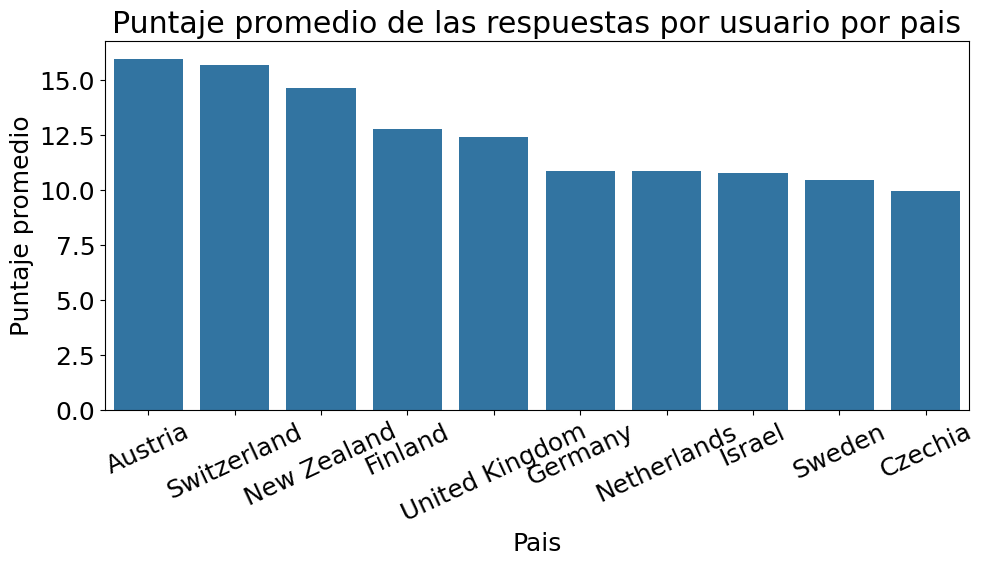

In [42]:
sns.barplot(mean_score_per_country, x="country", y="mean_score", color="tab:blue")
plt.xticks(rotation=25)
plt.title("Puntaje promedio de las respuestas por usuario por pais")
plt.xlabel("Pais")
plt.ylabel("Puntaje promedio")
plt.tight_layout()
plt.savefig("mean_score_per_country.png")

In [34]:
with connection:
    with connection.cursor() as cursor:
        cursor.execute(
            """
        with score_per_country as (
            select u.country, sum(score) as total_score
            from posts_19 p
            join users u on p.owner_user_id=u.id
            where u.country is not null and p.post_type_id=2
            group by u.country),
        users_per_country as (
            select u.country, count(*) as total_users
            from users u
            where u.country is not null
            and u.country != 'Error'
            group by u.country
            having count(*)>10000)
        select upc.country, total_score::decimal/total_users as mean_score
        from score_per_country spc join users_per_country upc on spc.country=upc.country
        order by mean_score asc
        limit 10"""
        )
        mean_score_per_country_low = pd.DataFrame(
            cursor.fetchall(), columns=["country", "mean_score"]
        )

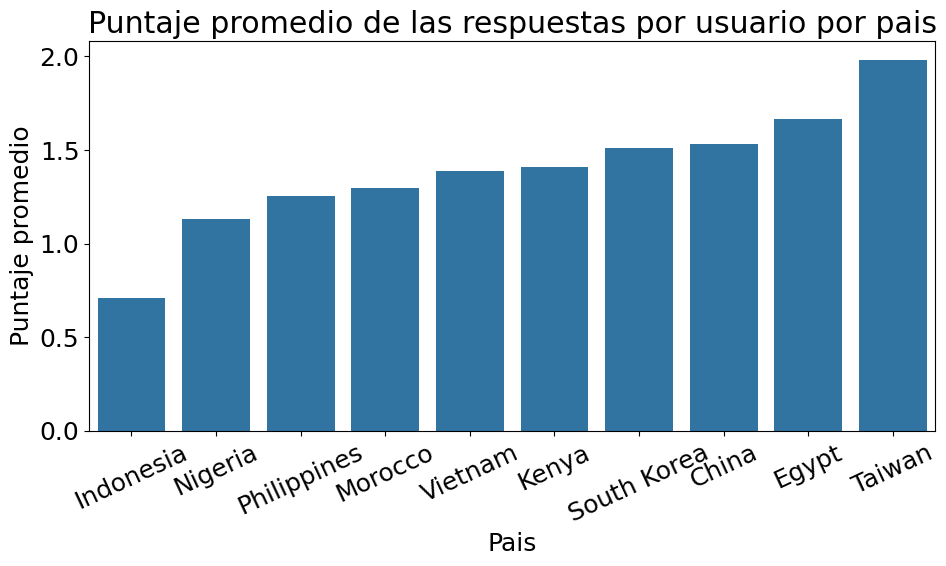

In [41]:
sns.barplot(mean_score_per_country_low, x="country", y="mean_score", color="tab:blue")
plt.xticks(rotation=25)
plt.title("Puntaje promedio de las respuestas por usuario por pais")
plt.xlabel("Pais")
plt.ylabel("Puntaje promedio")
plt.tight_layout()
plt.savefig("mean_score_per_country_low.png")

In [36]:
with connection:
    with connection.cursor() as cursor:
        cursor.execute(
            """
        with accepted_answer_per_country as (
            select u.country, count(*) as total_aa
            from posts_19 p
            inner join users u on p.owner_user_id=u.id
            inner join posts_19 q on q.accepted_answer_id = p.id
            where u.country is not null and q.post_type_id=1 and p.post_type_id=2
            group by u.country),
        users_per_country as (
            select u.country, count(*) as total_users
            from users u
            where u.country is not null
            group by u.country
            having count(*)>10000)
        select upc.country, total_aa::decimal/total_users as mean_aa
        from accepted_answer_per_country aapc join users_per_country upc on aapc.country=upc.country
        order by mean_aa desc
        limit 10"""
        )
        mean_aa_per_country = pd.DataFrame(
            cursor.fetchall(), columns=["country", "mean_aa"]
        )

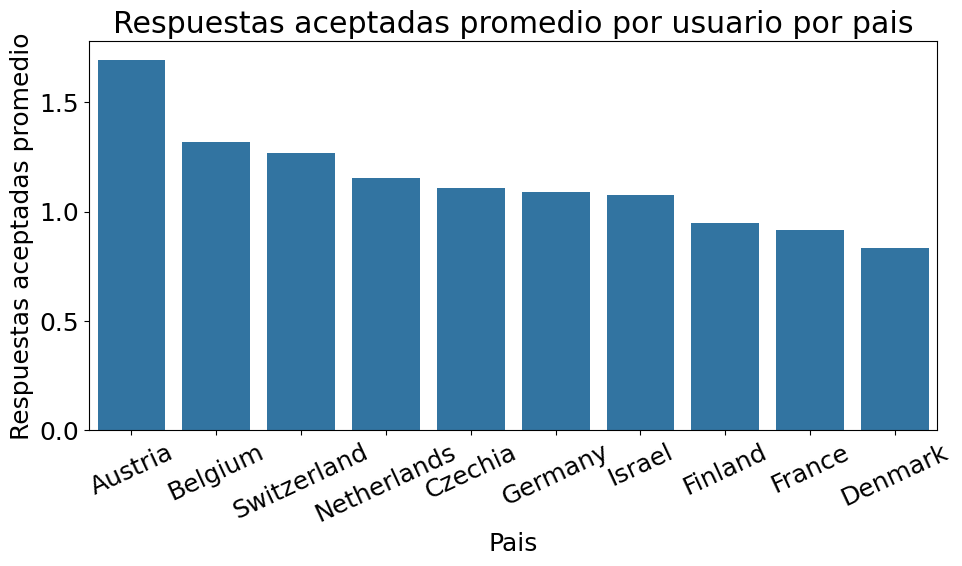

In [44]:
sns.barplot(mean_aa_per_country, x="country", y="mean_aa", color="tab:blue")
plt.xticks(rotation=25)
plt.title("Respuestas aceptadas promedio por usuario por pais");
plt.xlabel("Pais")
plt.ylabel("Respuestas aceptadas promedio")
plt.tight_layout()
plt.savefig("mean_aa_per_country.png")

In [38]:
with connection:
    with connection.cursor() as cursor:
        cursor.execute(
            """
        with u_accepted_answer_per_country as (
            select u.country, count(DISTINCT u.id) as users_with_aa
            from posts_19 p
            inner join users u on p.owner_user_id=u.id
            inner join posts_19 q on q.accepted_answer_id = p.id
            where u.country is not null and q.post_type_id=1 and p.post_type_id=2
            group by u.country),
        u_answer_per_country as (
            select u.country, count(DISTINCT u.id) as users_with_a
            from posts_19 p
            inner join users u on p.owner_user_id=u.id
            where u.country is not null and p.post_type_id=2
            group by u.country
            having count(*)>10000)
        select uapc.country, (users_with_a-users_with_aa)::decimal/users_with_a as users_wo_aa_prop
        from u_answer_per_country uapc join u_accepted_answer_per_country uaapc on uapc.country=uaapc.country
        order by users_wo_aa_prop desc
        limit 10"""
        )
        users_wo_aa_prop_per_country = pd.DataFrame(
            cursor.fetchall(), columns=["country", "users_wo_aa_prop"]
        )

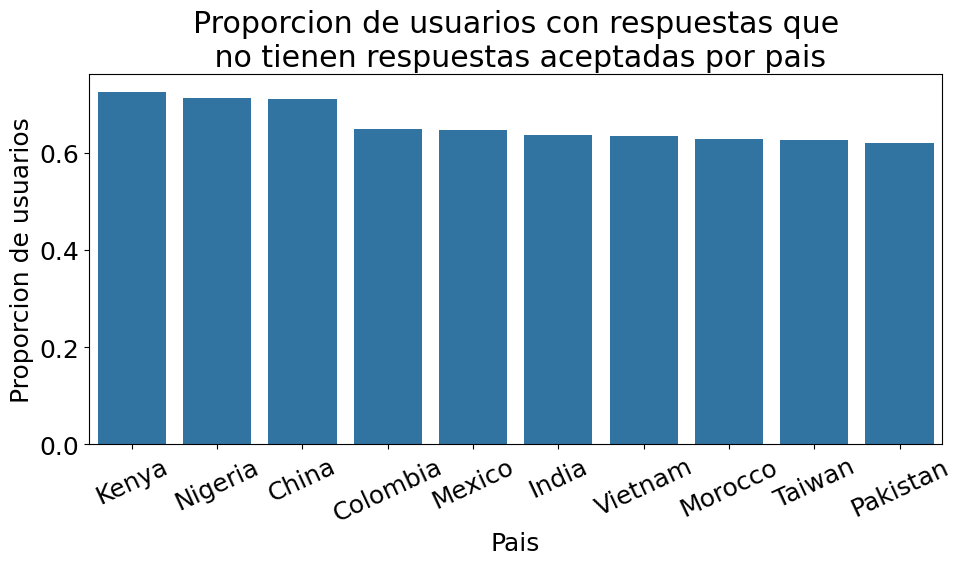

In [48]:
sns.barplot(users_wo_aa_prop_per_country, x="country", y="users_wo_aa_prop", color="tab:blue")
plt.xticks(rotation=25)
plt.title("Proporcion de usuarios con respuestas que\n no tienen respuestas aceptadas por pais");
plt.xlabel("Pais")
plt.ylabel("Proporcion de usuarios")
plt.tight_layout()
plt.savefig("users_wo_aa_prop_per_country.png")